In [1]:
import setGPU

import tensorflow as tf

import csv, os, shutil
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import seaborn as sns
import pandas as pd
import bm3d

setGPU: Setting GPU to: 0


/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3

### load csv file and separate the data based on different classes ###

In [2]:
csv_file_path = '../data/gicsd_labels.csv'
src_data_path = '../data/images'
classes_data_path = '../data/classes'
if not os.path.exists(classes_data_path):
    os.makedirs(classes_data_path)

In [3]:
data = pd.read_csv(csv_file_path, header=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   IMAGE_FILENAME  800 non-null    object
 1    LABEL          800 non-null    object
dtypes: object(2)
memory usage: 12.6+ KB


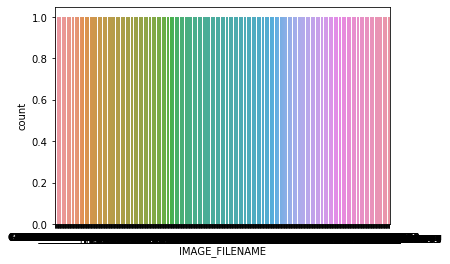

In [4]:
sns.countplot(x="IMAGE_FILENAME", data=data)

In [5]:
def read_csv_file():
    with open(csv_file_path) as file:
        reader = csv.reader(file)
        try:
            for row in reader:
                if row[0] == 'IMAGE_FILENAME' or row[1] == 'LABEL':
                    continue
                src_file_path = os.path.join(src_data_path, row[0])
                dst_path = os.path.join(classes_data_path, row[1].strip())
                if not os.path.exists(dst_path):
                    os.makedirs(dst_path)
                dst_file_path = os.path.join(dst_path, row[0])
                shutil.copy(src_file_path, dst_file_path)
                    
        except csv.Error as e:
            sys.exit('line {}, {}'.format(reader.line_num, e))

In [6]:
read_csv_file()

In [84]:
def display_samples_distribution(classes, each_class_samples):
    index = np.arange(len(classes))
    plt.bar(index, each_class_samples)
    plt.xlabel('Genre', fontsize=5)
    plt.ylabel('No of samples', fontsize=5)
    plt.xticks(index, classes, fontsize=5, rotation=30)
    plt.title('No of samples in each class')
    plt.show()

646 123 31


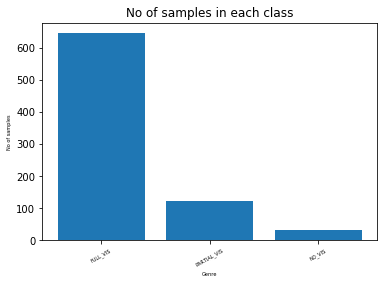

In [85]:
fv_path = '../data/classes/FULL_VISIBILITY'
pv_path = '../data/classes/PARTIAL_VISIBILITY'
nv_path = '../data/classes/NO_VISIBILITY'

images_fv = os.listdir(fv_path)
images_pv = os.listdir(pv_path)
images_nv = os.listdir(nv_path)
print(len(images_fv), len(images_pv), len(images_nv))

classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(images_fv), len(images_pv), len(images_nv)]

display_samples_distribution(classes, each_class_samples)

### analyse  a few samples in each category by displaying them ###

In [7]:
def display_images(images_fv, images_pv, images_nv, n):
    plt.figure(figsize=(24,4))
    for i in range(n):
        ax = plt.subplot(3, n, i+1)
        if i == 0:
            plt.title('fv_images', fontsize=12)
        plt.imshow(images_fv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax = plt.subplot(3, n, i+1+n)
        if i == 0:
            plt.title('pv_images', fontsize=12)
        plt.imshow(images_pv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
        ax = plt.subplot(3, n, i+1+2*n)
        if i == 0:
            plt.title('nv_images', fontsize=12)
        plt.imshow(images_nv[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

646 123 31


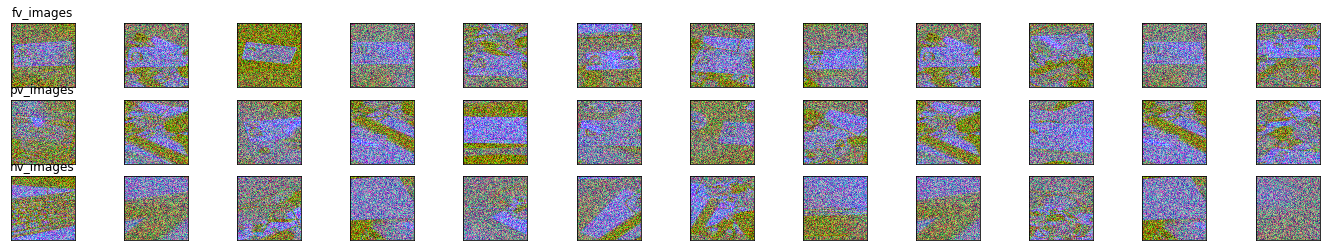

In [8]:
raw_images_fv = []
raw_images_pv = []
raw_images_nv = []
n = 12
for i in range(n):
    rInd = np.random.randint(0, len(images_nv)-1)
    raw_images_fv.append(cv.cvtColor(cv.imread(os.path.join(fv_path, images_fv[rInd])), cv.COLOR_BGR2RGB))
    raw_images_pv.append(cv.cvtColor(cv.imread(os.path.join(pv_path, images_pv[rInd])), cv.COLOR_BGR2RGB))
    raw_images_nv.append(cv.cvtColor(cv.imread(os.path.join(nv_path, images_nv[rInd])), cv.COLOR_BGR2RGB))
    
display_images(raw_images_fv, raw_images_pv, raw_images_nv, n)

### anaylise a single image to check the noise level and each channel, used BM3D algo to check if it can denoise given image ###

In [9]:
def display_single_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

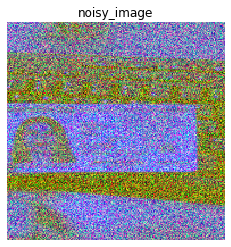

In [10]:
img = cv.cvtColor(cv.imread(os.path.join(fv_path, images_fv[0])), cv.COLOR_BGR2RGB)
display_single_image(img, 'noisy_image')

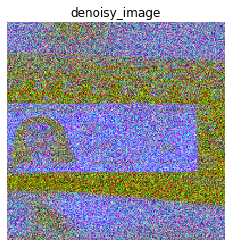

In [11]:
denoised_image = bm3d.bm3d(img + 0.5, sigma_psd=30/255, stage_arg=bm3d.BM3DStages.ALL_STAGES)#HARD_THRESHOLDING)
d_img = denoised_image.astype(np.uint8)

display_single_image(d_img, 'denoisy_image')

original image shape:(192, 192, 3), single channel shape:(192, 192)


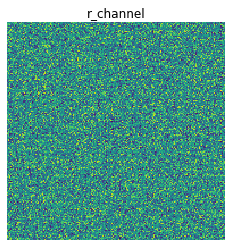

In [12]:
r, g, b = cv.split(img)
print("original image shape:{}, single channel shape:{}".format(img.shape, b.shape))
display_single_image(r, 'r_channel')

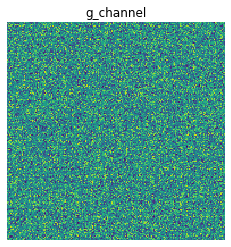

In [13]:
display_single_image(g, 'g_channel')

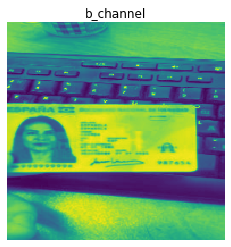

In [14]:
display_single_image(b, 'b_channel')

In [90]:
def get_single_channel_image(file_path):
    img = cv.imread(file_path)
    b, g, r = cv.split(img)
    return b

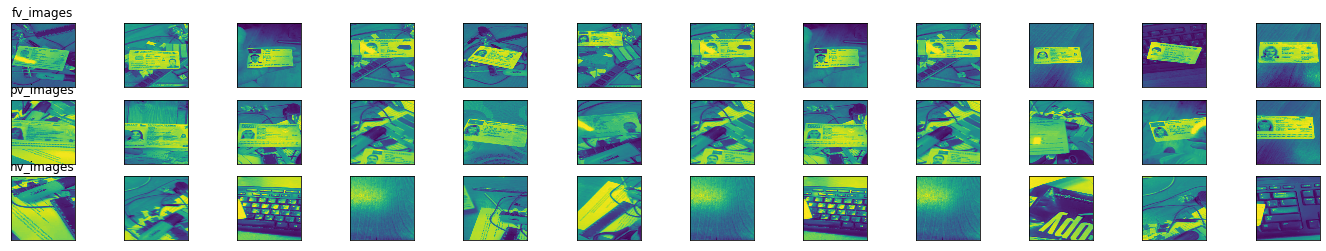

In [91]:
raw_images_fv = []
raw_images_pv = []
raw_images_nv = []
n = 12
for i in range(n):
    rInd = np.random.randint(0, len(images_nv)-1)
    raw_images_fv.append(get_single_channel_image(os.path.join(fv_path, images_fv[rInd])))
    raw_images_pv.append(get_single_channel_image(os.path.join(pv_path, images_pv[rInd])))
    raw_images_nv.append(get_single_channel_image(os.path.join(nv_path, images_nv[rInd])))
    
display_images(raw_images_fv, raw_images_pv, raw_images_nv, n)

### single channels images - extract sharp data from noisy data and dump them as separate files ###

In [92]:
"""
Sepearte the single channle image form original noisy image and dumps in the given path
@aug_data_path: path where all the augmented or oringal images present
@single_channel_path: path where all single channel images will be stored
"""
def dump_single_channel_image(aug_data_path, single_channel_path):
    files = os.listdir(aug_data_path)
    for file in files:
        file_path = os.path.join(aug_data_path, file)

        img = get_single_channel_image(file_path)
        base, ext = file.split('.')
        file_name = base+'_SC'+'.'+ext
        sc_file_path = os.path.join(single_channel_path, file_name)
        cv.imwrite(sc_file_path, img)

In [93]:
"""Extract single channel images and store them in the created files"""

fv_single_channel_path = '../data/single_channel_images/FULL_VISIBILITY'
if not os.path.exists(fv_single_channel_path):
    os.makedirs(fv_single_channel_path)

pv_single_channel_path = '../data/single_channel_images/PARTIAL_VISIBILITY'
if not os.path.exists(pv_single_channel_path):
    os.makedirs(pv_single_channel_path)

nv_single_channel_path = '../data/single_channel_images/NO_VISIBILITY'
if not os.path.exists(nv_single_channel_path):
    os.makedirs(nv_single_channel_path)

""" full_visibility files path """
fv_aug_path = '../data/classes_aug/FULL_VISIBILITY'
dump_single_channel_image(fv_aug_path, fv_single_channel_path)
    
""" partial_visibility files path """
pv_aug_path = '../data/classes_aug/PARTIAL_VISIBILITY'
dump_single_channel_image(pv_aug_path, pv_single_channel_path)
    
""" no_visibility files path """
nv_aug_path = '../data/classes_aug/NO_VISIBILITY'
dump_single_channel_image(nv_aug_path, nv_single_channel_path)

In [ ]:
""" check the distribution of single channel images"""
classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(os.listdir(fv_single_channel_path)), len(os.listdir(pv_single_channel_path)), len(os.listdir(nv_single_channel_path))]
display_samples_distribution(classes, each_class_samples)

### Over-sampling by applying data augmentation ###

In [74]:
def generate_aug_file_names(filename, ind):
    head, tail = os.path.split(filename)
    base, ext = tail.split('.')
    nfilename = base+str(ind)+'.'+ext
    file_path = os.path.join(head, nfilename)
    return file_path

In [75]:
"""
@src_file_path: path fo the original image
@aug_file_path: path where the augmented file needs to be copied
@angle: roation angle
@operation: what operation should be applied to augment the data
"""
def augment_file(src_file_path, aug_file_path, angle, class_type, operation):
    img = cv.imread(src_file_path)
    b, g, r = cv.split(img)
    img_to_arr = tf.keras.preprocessing.image.img_to_array(img)
    sample = np.expand_dims(img_to_arr, 0)
    if operation == 'rotation':
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=angle)
    elif operation == 'brightness':
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(brightness_range=[0.2,1.0])
    elif operation == 'zoom':
        datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5,1.0])
    
    no_of_samples_to_consider = 1
    if class_type == 'no_vis':
        no_of_samples_to_consider = 2
        
    it = datagen.flow(sample, batch_size = 1)
    for ind in range(no_of_samples_to_consider):
        batch_ = it.next()
        aug_file_path = generate_aug_file_names(aug_file_path, ind)
        cv.imwrite(aug_file_path, batch_[0].astype(np.uint8))
    
    #display_single_image(batch_[0].asytpe(np.uint8))

In [76]:
"""
@aug_data_path: where augmented data needs to be stored
@files_path: where all the original class data stored
@angles: list contains all the angles that we want to rotate an image
@operation: by default it is rotation
"""
def trigger_rotation_aug(aug_data_path, files_path, angles, class_type, operation='rotation'):
    """ Create a base path if does not exists already """
    if not os.path.exists(aug_data_path):
        os.makedirs(aug_data_path)
        
    """ Dump the images in particular operation for more clarity to visualize """
    aug_data_path = os.path.join(aug_data_path, operation) 
    if not os.path.exists(aug_data_path):
        os.makedirs(aug_data_path)

    files = os.listdir(files_path)
    def process_aug(operation, angle=0):
        for file in files:
            src_file_path = os.path.join(files_path, file)

            """ create augment file path where it is needs to be saved"""
            base, ext = file.split('.')
            if operation == 'rotation':
                aug_file_name = base+'_rot_'+str(angle)+'.'+ext
            else:
                aug_file_name = base+'_'+operation+'.'+ext
            aug_file_path = os.path.join(aug_data_path, aug_file_name)
            
            augment_file(src_file_path, aug_file_path, angle, class_type, operation)

    if operation == 'rotation':
        for angle in angles:
            process_aug(angle, operation)
    elif operation == 'zoom':
        process_aug(operation)
    elif operation == 'brightness':
        process_aug(operation)

In [78]:
""" Augment data with different roation analges"""
class_type = 'no_vis'
operation = 'zoom'
if class_type == 'no_vis':
    nv_angles = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170]
    nv_aug_data_path = '../data/aug_data/NO_VISIBILITY'
    trigger_rotation_aug(nv_aug_data_path, nv_path, nv_angles, class_type, operation)
elif class_type == 'partial_vis':
    pv_angles = [30, 60, 90, 120, 150]
    pv_aug_data_path = '../data/aug_data/PARTIAL_VISIBILITY'
    trigger_rotation_aug(pv_aug_data_path, pv_path, pv_angles, class_type, operation)
elif class_type == 'full_vis':
    fv_angle = [90]
    fv_aug_data_path = '../data/aug_data/FULL_VISIBILITY'
    trigger_rotation_aug(fv_aug_data_path, fv_path, fv_angle, class_type, operation)

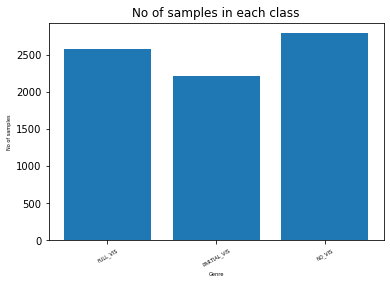

In [94]:
fv_class_aug_data_path = '../data/classes_aug/FULL_VISIBILITY'
pv_class_aug_data_path = '../data/classes_aug/PARTIAL_VISIBILITY'
nv_class_aug_data_path = '../data/classes_aug/NO_VISIBILITY'

classes=['FULL_VIS', 'PARTIAL_VIS', 'NO_VIS']
each_class_samples = [len(os.listdir(fv_class_aug_data_path)), len(os.listdir(pv_class_aug_data_path)), len(os.listdir(nv_class_aug_data_path))]
display_samples_distribution(classes, each_class_samples)

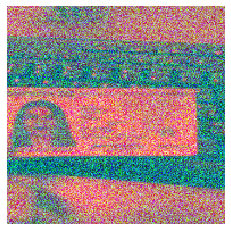

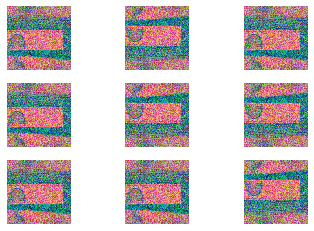

In [36]:
data = cv.imread(os.path.join(fv_path, images_fv[0]))
plt.imshow(data)
plt.axis('off')
plt.show()
samples = np.expand_dims(data, 0)
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(zoom_range=[0.5,1.0]) 
datagen = tf.keras.preprocessing.image.ImageDataGenerator(vertical_flip=True)
it = datagen.flow(samples, batch_size=1)
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image6 = batch[0].astype('uint8')
    plt.imshow(image6)
    plt.axis('off')

plt.show()